In [ ]:
import os
import math
# import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import preprocessing


%matplotlib inline

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2022-09-19 14:23:54--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  3.23MB/s    in 1.7s    

2022-09-19 14:23:57 (3.23 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]



In [ ]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/movies.dat        
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
BASE_DIR = '/content'
MOVIELENS_DIR = os.path.join(BASE_DIR, 'ml-1m')

USERS_DATA_FILE = 'users.dat'
MOVIES_DATA_FILE = 'movies.dat'
RATINGS_DATA_FILE = 'ratings.dat'

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'

In [ ]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATINGS_DATA_FILE),
                      sep='::',
                      engine='python',
                      encoding='latin-1',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [ ]:
max_user_id = ratings['user_id'].drop_duplicates().max()
max_movie_id = ratings['movie_id'].drop_duplicates().max()

ratings['new_user_id'] = ratings['user_id'] - 1
ratings['new_movie_id'] = ratings['movie_id'] - 1

print(f"{len(ratings)} ratings loaded")

ratings.to_csv(RATINGS_CSV_FILE,
               sep='\t',
               header=True,
               encoding='latin',
               columns=['new_user_id', 'new_movie_id', 'rating', 'timestamp'])

print(f"Saved to {RATINGS_CSV_FILE}")

1000209 ratings loaded
Saved to ml1m_ratings.csv


In [ ]:
df = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1',
                 usecols=['new_user_id', 'new_movie_id', 'rating', 'timestamp'])
df.head()

,new_user_id,new_movie_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [ ]:
df.tail()

,new_user_id,new_movie_id,rating,timestamp
1000204,6039,1090,1,956716541
1000205,6039,1093,5,956704887
1000206,6039,561,5,956704746
1000207,6039,1095,4,956715648
1000208,6039,1096,4,956715569


In [ ]:
le_user = preprocessing.LabelEncoder()
df.loc[:, 'new_user_id'] = le_user.fit_transform(df['new_user_id'].values)

le_item = preprocessing.LabelEncoder()
df.loc[:, 'new_movie_id'] = le_item.fit_transform(df['new_movie_id'].values)

In [ ]:
num_users = df['new_user_id'].nunique()
num_movies = df['new_movie_id'].nunique()

(num_users, num_movies)

(6040, 3706)

In [ ]:
train_df, test_df = train_test_split(df,
                                     stratify=df['new_user_id'],
                                     test_size=0.1,
                                     random_state=3)

In [ ]:
train_df, val_df = train_test_split(train_df,
                                    stratify=train_df['new_user_id'],
                                    test_size=0.1,
                                    random_state=3)

In [ ]:
(train_df.shape, val_df.shape, test_df.shape)

((810169, 4), (90019, 4), (100021, 4))

In [ ]:
def dataPreprocessor(ratings_df, num_users, num_items, init_value=0.0, 
                     average=False):
    if not average:
        matrix = np.full((num_users, num_items), init_value)
        for (_, user_id, movie_id, rating, _) in ratings_df.itertuples():
            matrix[user_id, movie_id] = rating
    else:
        matrix = np.full((num_users, num_items), 0.0)
        for(_, user_id, movie_id, rating, _) in ratings_df.itertuples():
            matrix[user_id, movie_id] = rating
        avg_user_rating = matrix.sum(axis=1) / np.maximum((matrix!=0).sum(axis=1), 1)
        unobserved_entries = np.where(matrix==0)
        matrix[unobserved_entries] = np.take(avg_user_rating, 
                                             unobserved_entries[0])
        
        

    return matrix

In [ ]:
user_item_matrix_train = dataPreprocessor(train_df, num_users, num_movies)

user_item_matrix_train_avg = dataPreprocessor(train_df, num_users, num_movies, 
                                             average=True)
user_item_matrix_val = dataPreprocessor(val_df, num_users, num_movies)
user_item_matrix_test = dataPreprocessor(test_df, num_users, num_movies)

In [ ]:
num_latent_factors = [5,10,15,20]

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dot

In [ ]:
movie_input = tf.keras.Input(shape=(1,), name='Item')
movie_embedding = Embedding(num_movies, num_latent_factors[0], input_length=1, name='MovieEmbedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = tf.keras.Input(shape=(1,), name='User')
user_embedding = Embedding(num_users, num_latent_factors[0], input_length=1, name='UserEmbedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])

model = tf.keras.Model([user_input, movie_input], prod)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 MovieEmbedding (Embedding)     (None, 1, 5)         18530       ['Item[0][0]']                   
                                                                                                  
 UserEmbedding (Embedding)      (None, 1, 5)         30200       ['User[0][0]']                   
                                                                                            

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

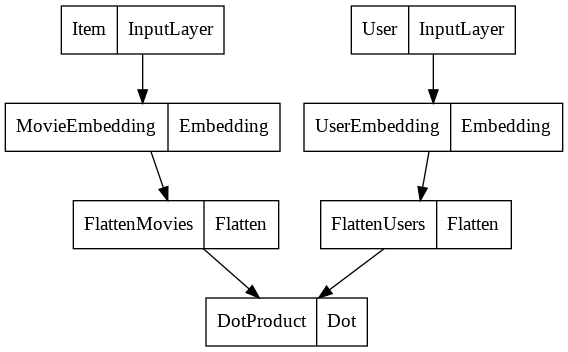

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
history = model.fit([train_df.new_user_id, train_df.new_movie_id], 
                    train_df.rating,
                    batch_size=512,
                    epochs=50,
                    validation_data=([val_df.new_user_id, val_df.new_movie_id], val_df.rating))

Epoch 1/50
1583/1583 [==============================] - 6s 4ms/step - loss: 9.7355 - root_mean_squared_error: 3.1202 - val_loss: 3.2484 - val_root_mean_squared_error: 1.8023
Epoch 2/50
1583/1583 [==============================] - 5s 3ms/step - loss: 1.9208 - root_mean_squared_error: 1.3859 - val_loss: 1.2784 - val_root_mean_squared_error: 1.1307
Epoch 3/50
1583/1583 [==============================] - 6s 3ms/step - loss: 1.0926 - root_mean_squared_error: 1.0453 - val_loss: 0.9691 - val_root_mean_squared_error: 0.9844
Epoch 4/50
1583/1583 [==============================] - 5s 3ms/step - loss: 0.9167 - root_mean_squared_error: 0.9574 - val_loss: 0.8834 - val_root_mean_squared_error: 0.9399
Epoch 5/50
1583/1583 [==============================] - 5s 3ms/step - loss: 0.8633 - root_mean_squared_error: 0.9292 - val_loss: 0.8546 - val_root_mean_squared_error: 0.9244
Epoch 6/50
1583/1583 [==============================] - 6s 3ms/step - loss: 0.8446 - root_mean_squared_error: 0.9190 - val_loss: 0

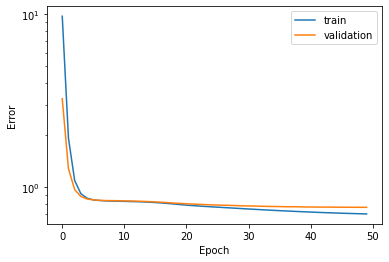

In [ ]:
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['train', 'validation'], loc='best')

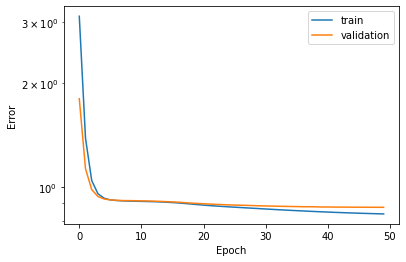

In [ ]:
pd.Series(history.history['root_mean_squared_error']).plot(logy=True)
pd.Series(history.history['val_root_mean_squared_error']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(['train', 'validation'], loc='best')

In [ ]:
test_results = model.evaluate((test_df.new_user_id, test_df.new_movie_id), 
                              test_df.rating)
print(test_results)

3126/3126 [==============================] - 6s 2ms/step - loss: 0.7697 - root_mean_squared_error: 0.8773
[0.7696875929832458, 0.8773183822631836]


In [ ]:
movie_embedding_learnt = model.get_layer(name='MovieEmbedding').get_weights()[0]
user_embedding_learnt = model.get_layer(name='UserEmbedding').get_weights()[0]

In [ ]:
def recommend(user_id, number_of_movies=10):
    movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
    mvs_seen = list(train_df[train_df['new_user_id']==user_id]['new_movie_id'])
    np.put(movies, mvs_seen, 0)
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    recs = [(mvs_dict[i], movies[i]) for i in mids]
    return pd.DataFrame(recs, columns=['Movie', 'Predicted Rating']).sort_values(by='Predicted Rating',
                                    ascending=False)

In [ ]:
from IPython.display import HTML
HTML(recommend(user_id=37).to_html(index=False))

Movie,Predicted Rating
Modulations (1998),4.936861
Foreign Student (1994),4.892438
Chain of Fools (2000),4.820889
Schlafes Bruder (Brother of Sleep) (1995),4.812675
"Shawshank Redemption, The (1994)",4.660031
Schindler's List (1993),4.625842
Lured (1947),4.574214
Saving Private Ryan (1998),4.545629
Dances with Wolves (1990),4.538051
Identification of a Woman (Identificazione di una donna) (1982),4.509336


In [ ]:
recommend(user_id=37)

,Predicted Rating
Movie,
Modulations (1998),4.936861
Foreign Student (1994),4.892438
Chain of Fools (2000),4.820889
Schlafes Bruder (Brother of Sleep) (1995),4.812675
"Shawshank Redemption, The (1994)",4.660031
Schindler's List (1993),4.625842
Lured (1947),4.574214
Saving Private Ryan (1998),4.545629
Dances with Wolves (1990),4.538051


In [ ]:
mvs = pd.read_csv('ml-1m/movies.dat', sep='::', encoding='latin-1', 
            header=None,
            engine='python')
mvs.columns = ['movie_id', 'movie', 'genre']
mvs

,movie_id,movie,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
r_mvs = pd.Series(ratings['movie_id'].unique(), name='movie_id')

In [ ]:
mvs_df = mvs.merge(r_mvs, how='inner',)
mvs_df.head()

,movie_id,movie,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
mvs_df['new_movie_id'] = le_item.transform(mvs_df['movie_id']-1)

In [ ]:
mvs_df.head()

,movie_id,movie,genre,new_movie_id
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [ ]:
mvs_dict = pd.Series(mvs_df['movie'], index=mvs_df['new_movie_id']).to_dict()

In [ ]:
ratings[(ratings['new_user_id']==0) & (ratings['rating']>3)].sort_values('rating', ascending=False)

,user_id,movie_id,rating,timestamp,new_user_id,new_movie_id
0,1,1193,5,978300760,0,1192
14,1,1035,5,978301753,0,1034
37,1,1022,5,978300055,0,1021
39,1,150,5,978301777,0,149
40,1,1,5,978824268,0,0
41,1,1961,5,978301590,0,1960
25,1,48,5,978824351,0,47
23,1,527,5,978824195,0,526
22,1,1270,5,978300055,0,1269
18,1,3105,5,978301713,0,3104
